In [1]:
import numpy as np
import pandas as pd
import copy
import math

from collections import Counter

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
def init_model(N, states, weights, ages, spread=3):
    init_states = np.random.choice(states, N, p=weights, replace=True)
    cells = {}
    
    for i, state in enumerate(init_states): 
        age_lb = ages[state][0]
        age_ub = ages[state][1]
        age = np.random.poisson(spread, 1)[0] + age_lb
        
        if age >= age_ub:
            age = age_ub - 1
        
        cells[i] = {
            'state' : state,
            'age' : age,
        }
    return cells
     
    
N = 5
states = ['G1', 'S', 'G2'] 
weights = [0.5, 0.25, 0.25] 
ages = {
    'G1' : [0, 11],
    'S' : [12, 18],
    'G2' : [19, 25],
}

cells = init_model(N, states, weights, ages)
cells

{0: {'state': 'G1', 'age': 5},
 1: {'state': 'G1', 'age': 4},
 2: {'state': 'G1', 'age': 4},
 3: {'state': 'G2', 'age': 23},
 4: {'state': 'G1', 'age': 1}}

In [3]:
def count_state(cells):
    cell_states = [cells[c]['state'] for c in cells]
    return Counter(cell_states)
    

def simple_model(hours, cells, states, weights, ages):
    new_rows = []
    
    for h in range(hours):
        for c in list(cells):
            cell = cells[c]
            cell['age'] += 1 
            
            if cell['age'] > ages[cell['state']][1]:
                
                # increment cells in non-dividing state if age 
                # passes the threshold
                state_idx = states.index(cell['state'])
                if state_idx + 1 < len(states):
                    cell['state'] = states[state_idx + 1]
                else: 
                    # daughter 1
                    d1 = np.max(list(cells.keys())) + 1
                    cells[d1] = {
                        'state' : states[0],
                        'age' : ages[states[0]][0],
                    }
                    
                    # daughter 2
                    d2 = np.max(list(cells.keys())) + 1
                    
                    cells[d2] = {
                        'state' : states[0],
                        'age' : ages[states[0]][0],
                    }
                    
                    # mother perishes 
                    cells.pop(c)
        
        # store results
        row  = {
          'hour' : h,
          'n_cells' : len(cells),
        }
        
        state_counts = count_state(cells)
        
        for s, count in state_counts.items():
            row[s] =  float(count)
            
        new_rows.append(row)
        
    results = pd.DataFrame(new_rows)
    results = results.fillna(0)
    return results


hours = 72
N = 500
spread = 5
cells = init_model(N, states, weights, ages, spread)
df = simple_model(hours, cells, states, weights, ages)
print(f"{df.shape=}")
df.head()

df.shape=(72, 5)


,hour,n_cells,G1,G2,S
0,0,500,257.0,119.0,124.0
1,1,573,396.0,132.0,45.0
2,2,589,419.0,128.0,42.0
3,3,606,442.0,119.0,45.0
4,4,615,436.0,123.0,56.0


In [4]:
def instant_entropy(row, states):
    E = 0
    N = row['n_cells']
    for st in states:
        E += (row[st]/N) * np.log((row[st]/N))  
    return -E

df['instant_entropy'] = df.apply(lambda x: instant_entropy(x, states), axis=1)
print(f"{df.shape=}")
df.head()

df.shape=(72, 6)


,hour,n_cells,G1,G2,S,instant_entropy
0,0,500,257.0,119.0,124.0,1.029522
1,1,573,396.0,132.0,45.0,0.793347
2,2,589,419.0,128.0,42.0,0.762280
3,3,606,442.0,119.0,45.0,0.742896
4,4,615,436.0,123.0,56.0,0.783947


Text(0, 0.5, 'Entropy')

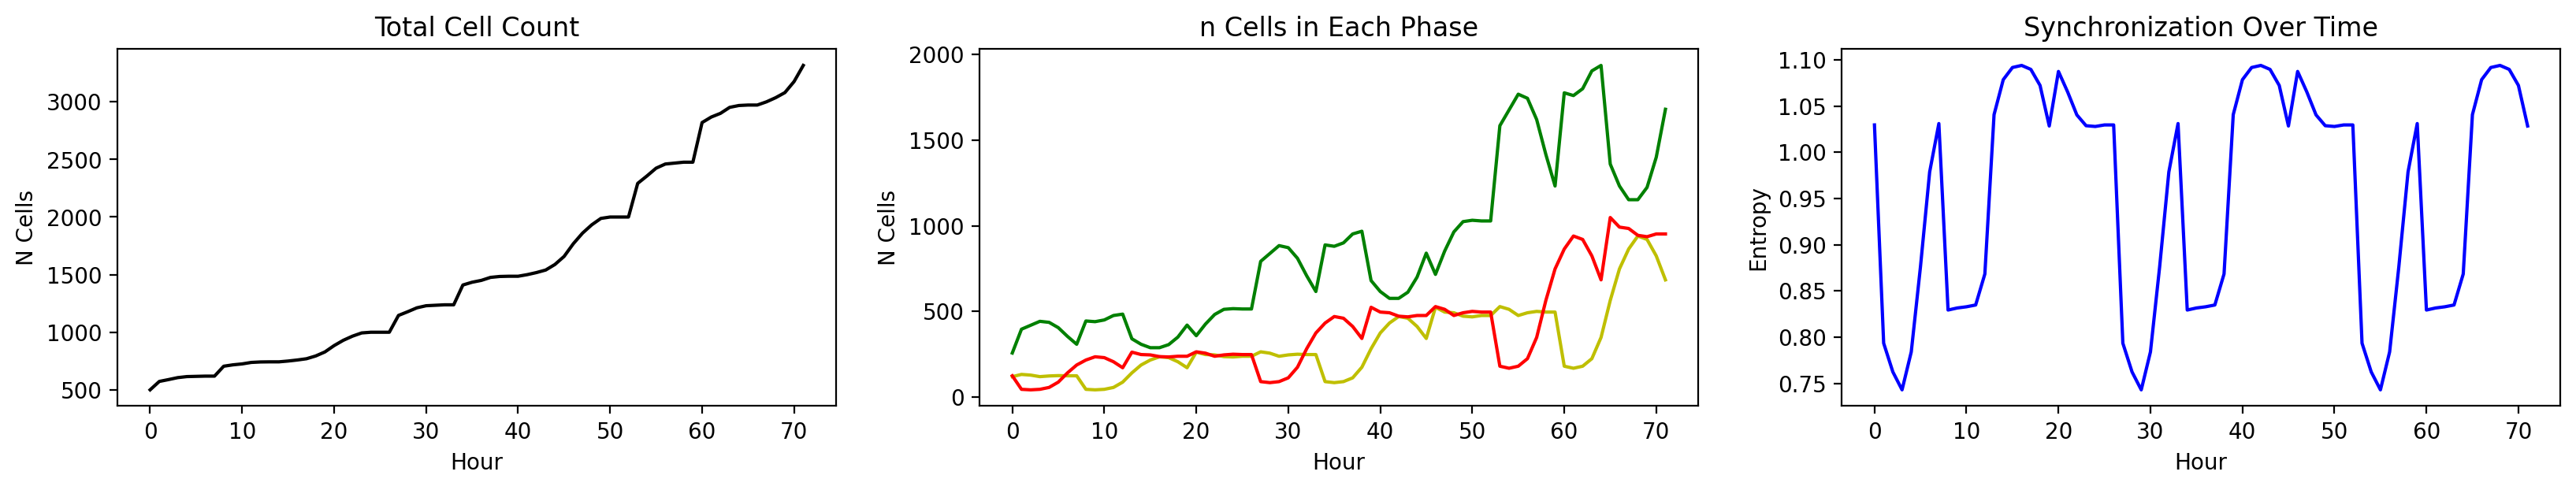

In [5]:
plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 20, 3
fig, (ax1, ax2, ax3) = plt.subplots(1, 3)

ax1.plot(df['hour'], df['n_cells'], c='k')
ax1.set_title("Total Cell Count")
ax1.set_xlabel("Hour")
ax1.set_ylabel("N Cells")

ax2.plot(df['hour'], df['G2'], c='y')
ax2.plot(df['hour'], df['G1'], c='g')
ax2.plot(df['hour'], df['S'], c='r')
ax2.set_title("n Cells in Each Phase")
ax2.set_xlabel("Hour")
ax2.set_ylabel("N Cells")

ax3.plot(df['hour'], df['instant_entropy'], c='b')
ax3.set_title("Synchronization Over Time")
ax3.set_xlabel("Hour")
ax3.set_ylabel("Entropy")

In [6]:
def stochastic_model(hours, cells, states, weights, ages, sigma=3):
    new_rows = []
    history = {}
    
    for h in range(hours):
        for c in list(cells):
            cell = cells[c]
            cell['age'] += 1 
            
            fudge = int(np.random.normal(0, sigma))
            
            if cell['age'] > ages[cell['state']][1] + fudge :
                
                # increment cells in non-dividing state if age 
                # passes the threshold
                state_idx = states.index(cell['state'])
                if state_idx + 1 < len(states):
                    cell['state'] = states[state_idx + 1]
                else: 
                    # daughter 1
                    d1 = np.max(list(cells.keys())) + 1
                    cells[d1] = {
                        'state' : states[0],
                        'age' : ages[states[0]][0],
                    }
                    
                    # daughter 2
                    d2 = np.max(list(cells.keys())) + 1
                    
                    cells[d2] = {
                        'state' : states[0],
                        'age' : ages[states[0]][0],
                    }
                    
                    # mother perishes 
                    cells.pop(c)
        
        # store results
        row  = {
          'hour' : h,
          'n_cells' : len(cells),
        }
        
        state_counts = count_state(cells)
        
        for s, count in state_counts.items():
            row[s] =  float(count)
            
        new_rows.append(row)
        history[h] = copy.deepcopy(cells)
        
    results = pd.DataFrame(new_rows)
    results = results.fillna(0)
    return results, history


hours = 96
N = 500
spread = 3
sigma = 1.5
weights = [0.95, 0.025, 0.025] 


cells = init_model(N, states, weights, ages, spread)
df, history = stochastic_model(hours, cells, states, weights, ages, sigma)
df['instant_entropy'] = df.apply(lambda x: instant_entropy(x, states), axis=1)
print(f"{df.shape=}")
df.head()

df.shape=(96, 6)


,hour,n_cells,G1,G2,S,instant_entropy
0,0,507,251.0,147.0,109.0,1.037507
1,1,532,299.0,147.0,86.0,0.973824
2,2,565,364.0,136.0,65.0,0.874843
3,3,591,414.0,124.0,53.0,0.793239
4,4,617,450.0,117.0,50.0,0.749120


In [7]:
def struct_history(history):
    """restructure history data """
    
    new_rows = []
    
    for h, cell_states in history.items():
        for c in cell_states:
            row = {
                'hour' : h,
                'cell' : c,
                'age' : cell_states[c]['age'],
                'state' : cell_states[c]['state'],
            }  
            new_rows.append(row)
            
    result = pd.DataFrame(new_rows)
    return result


h = struct_history(history)
h['n_records'] = h.groupby('cell')['state'].transform('count')
print(f"{h.shape=}")
h['n_records'].value_counts(dropna=False)

h.shape=(235426, 5)


26    70304
25    34650
27    21087
24    17472
23    10511
22     8250
21     7518
20     6440
19     6289
16     6032
17     5933
18     5562
15     5190
14     4158
13     4004
10     3660
12     3648
9      2853
11     2651
28     2492
8      2408
7      1624
6       984
5       625
4       376
2       242
1       213
3       192
29       58
Name: n_records, dtype: int64

In [8]:
# filter cells that have more than T hours of data
T = 22
print(f"{h.shape=}")
h = h[h['n_records'] > T]
print(f"{h.shape=}")

h.shape=(235426, 5)
h.shape=(156574, 5)


In [9]:

new_rows = []
    

for c in h['cell'].unique():
    
    tmp = h[h['cell'] == c]
    counts = dict(Counter(tmp['state']))
    
    for k, v in counts.items():
        row = {
            'state' : k,
            'hours' : v,
        }
        new_rows.append(row)

phase_lens = pd.DataFrame(new_rows)
print(f"{phase_lens.shape=}")
phase_lens.head()

phase_lens.shape=(18441, 2)


,state,hours
0,G1,7
1,S,9
2,G2,7
3,G1,9
4,S,8


Text(0, 0.5, 'Entropy')

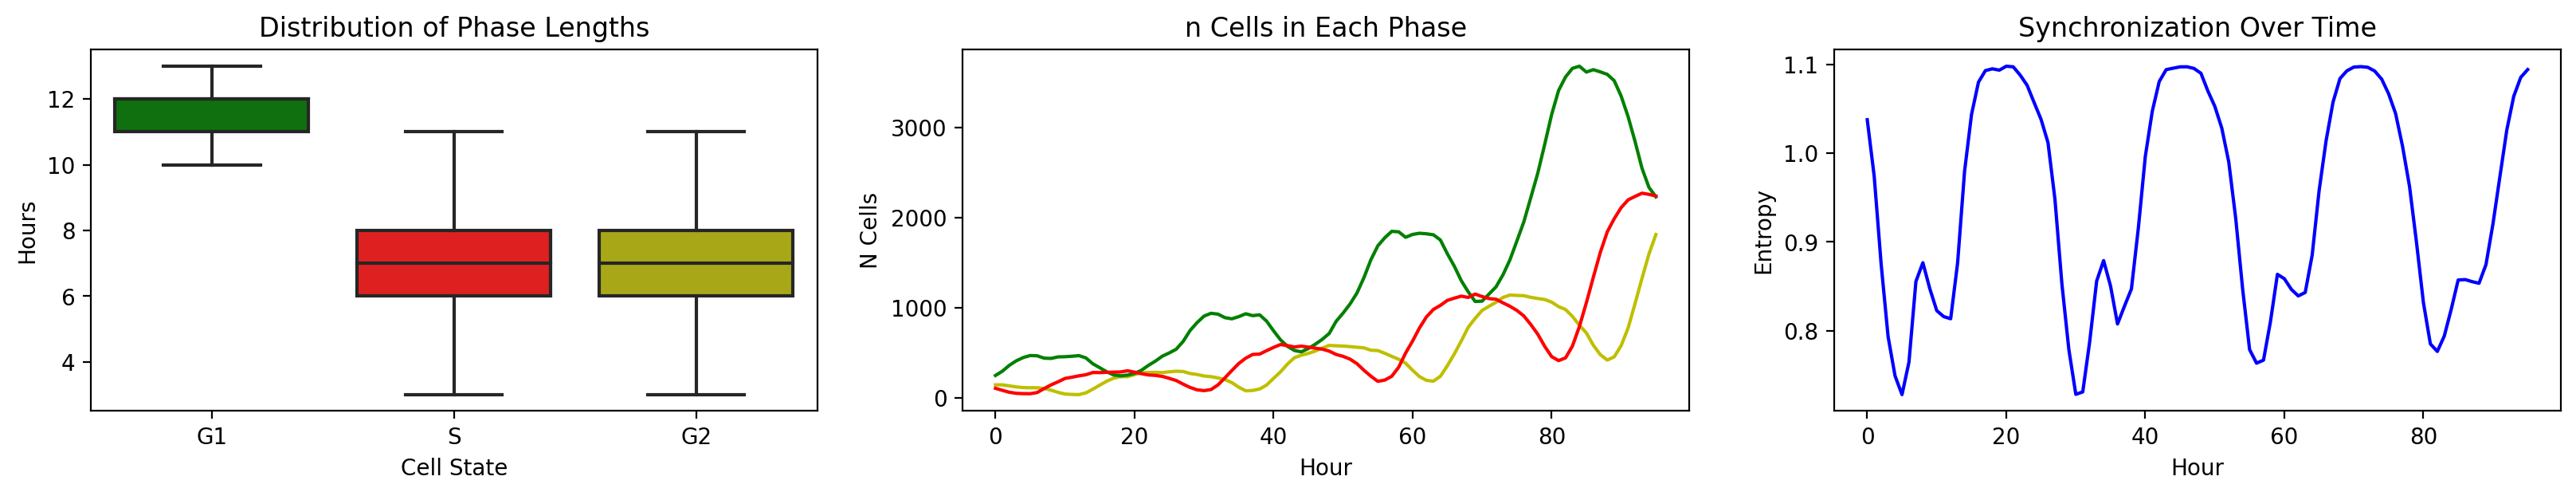

In [10]:
plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 20, 3
fig, (ax1, ax2, ax3) = plt.subplots(1, 3)

sns.boxplot(data=phase_lens,
            x='state',
            y='hours', 
            palette=['g', 'r', 'y'], 
            ax=ax1,
            showfliers=False)

ax1.set_title("Distribution of Phase Lengths")
ax1.set_xlabel("Cell State")
ax1.set_ylabel("Hours")

ax2.plot(df['hour'], df['G2'], c='y')
ax2.plot(df['hour'], df['G1'], c='g')
ax2.plot(df['hour'], df['S'], c='r')
ax2.set_title("n Cells in Each Phase")
ax2.set_xlabel("Hour")
ax2.set_ylabel("N Cells")

ax3.plot(df['hour'], df['instant_entropy'], c='b')
ax3.set_title("Synchronization Over Time")
ax3.set_xlabel("Hour")
ax3.set_ylabel("Entropy")

<ipython-input-11-e7b4a21ada3d>:5: RuntimeWarning: divide by zero encountered in log
  jsd = 0.5 * (x * np.log(x/m) + y * np.log(y/m))
<ipython-input-11-e7b4a21ada3d>:5: RuntimeWarning: invalid value encountered in double_scalars
  jsd = 0.5 * (x * np.log(x/m) + y * np.log(y/m))


Text(0, 0.5, '$\\mathbf{JSD} (x_i, 0.5)$')

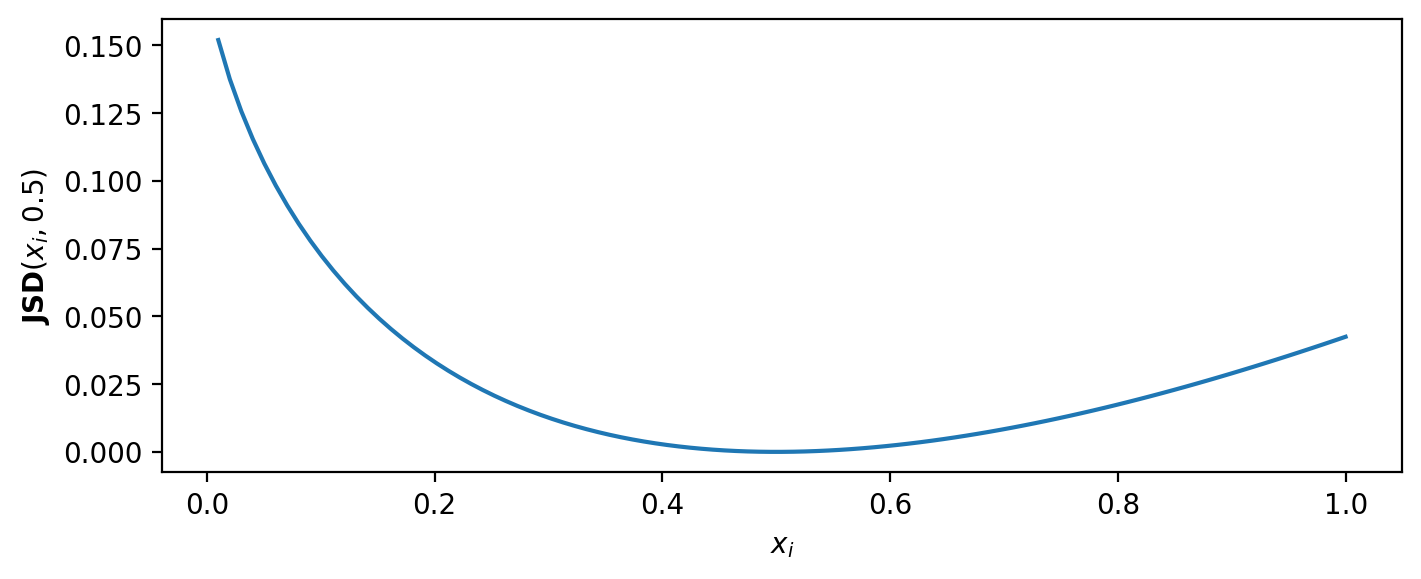

In [11]:
## Jenson-shannon divergence

def JSD(x, y):
    m = 0.5 * (x + y)
    jsd = 0.5 * (x * np.log(x/m) + y * np.log(y/m))
    return jsd


y = 0.5
x_list = np.linspace(0.0, 1.0, num=100)

jensen = []

for x in x_list:
    j  = JSD(x, y)
    jensen.append(j)
    

plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 8, 3
plt.plot(x_list, jensen)
plt.xlabel("$x_i$")
plt.ylabel("$\mathbf{JSD} (x_i, 0.5)$")

order=(0.014015416823043397-0.08011533332788622j)
order2=(0.014015416823043397-0.08011533332788622j)


(-1.0999978063561993,
 1.0999998955407715,
 -1.0999997513702215,
 1.0999986931237793)

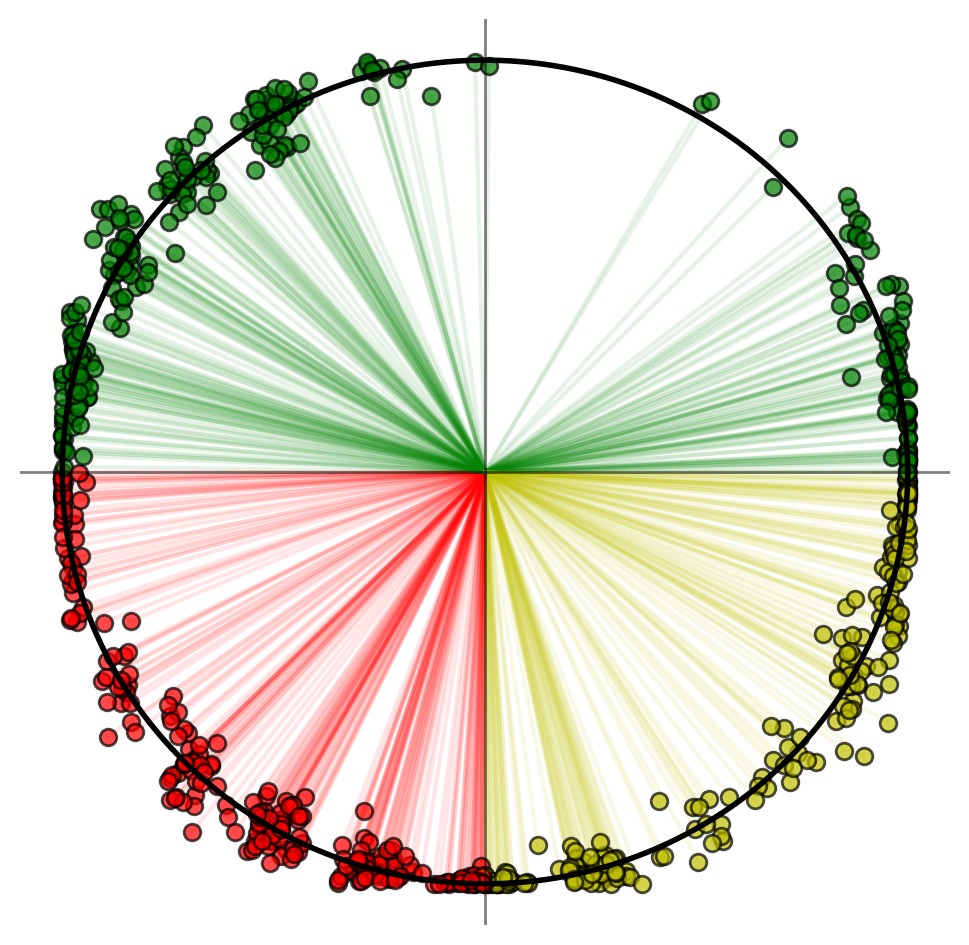

In [14]:
plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 6,6

# draw the unit cirlce
t = np.linspace(0, np.pi*2, 1000)
plt.plot(np.cos(t), np.sin(t), linewidth=2, c='k')


hour = 20
ages = h[h['hour'] == hour]['age']

order = np.sum([math.e ** (1j * x ) for x in ages]) / len(ages)
order2 = np.sum([(math.cos(x) + 1j*math.sin(x)) for x in ages]) / len(ages)

print(f"{order=}")
print(f"{order2=}")

#rescale ages 
ages = [(x/np.max(ages) * np.pi*2) for x in ages]

for c in ages:
    
    x = np.cos(c + np.random.normal(0, 0.05))
    y = np.sin(c + np.random.normal(0, 0.1))
    
    if y > 0:
        color = 'g'
    elif x < 0:
        color = 'r'
    else:
        color = 'y'
    
    
    plt.scatter(x, y, c=color, alpha=0.7, edgecolor='k')
    plt.plot([0, x], [0, y], alpha=0.1, c=color, zorder=0)

    
plt.axhline(y=0, color='k', alpha=0.5, lw=1)
plt.axvline(x=0, color='k', alpha=0.5, lw=1)
plt.axis('off')


In [13]:
type(1j)

complex